In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import math
from timeit import default_timer as timer

In [226]:
NUM_DIRECTIONS = 12
NUM_MOTIONS = 3 #forward, backward, no movement
NUM_TURNS = 3 # left, right, no turn

FORWARD = 1
BACKWARD = -1
RIGHT = 1
LEFT = -1
STILL = 0

class GameBoard:
    C = 0
    R = 0
    ss = None
    robot = None
    error_prob = 0
    policy_matrix = 0
    value_matrix = 0
    
    def __init__(self, C, R, error_prob):
        self.C = C
        self.R = R
        self.error_prob = error_prob
        self.ss = StateSpace(NUM_DIRECTIONS, self.C, self.R)
        self.robot = Robot(self.ss, 0,0,0)
        self.initializePolicyMatrix(State(0,3,4,0)) #this is specific for class
    
    
    # USER methods:
    def getValue(self, state):
        return self.value_matrix[state.direction][state.col][state.row]
    
    def getPolicy(self, state):
        return self.policy_matrix[state.direction][state.col][state.row]
    
    def runPolicyIteration(self, gamma):
        start = timer()
        self.initializeValueMatrix()
        stable = False
        count = 0
        while(stable == False):
            self.setValueMatrix(self.policy_matrix, gamma)
            stable = self.improvePolicy(gamma)
            count = count + 1
            #print(count)
        end = timer()
        print('Policy Iteration took ' + str(end-start) + ' seconds to run.\n')
    
    def runValueIteration(self, gamma):
        start = timer()
        self.initializeValueMatrix()
        delta = 1
        epsilon = 0.1
        actionspace = [Action(0,0),Action(1,-1),Action(1,0),Action(1,1),Action(-1,-1),Action(-1,0),Action(-1,1)]
        count = 0
        
        while(delta >= epsilon):
            delta = 0
            for i in range(NUM_DIRECTIONS): 
                for j in range(self.C):
                    for k in range(self.R):
                        v = self.value_matrix[i][j][k]
                        currState = self.ss.statespace[i][j][k]
                        m = -100000
                        bestAction = actionspace[0]
                        for a in range(len(actionspace)):
                            action = actionspace[a]
                            temp = self.calculateSummation(currState,action,gamma)
                            if(temp > m):
                                m = temp
                                bestAction = action
                        self.value_matrix[i][j][k] = m
                        self.policy_matrix[i][j][k] = bestAction
                        delta = max(delta, abs(v - m))
            count = count + 1
            #print(delta)
        end = timer()
        print('Value Iteration took ' + str(end-start) + ' seconds to run.\n')
                        

    def moveRobotManually(self, d, c, r):
        self.robot = Robot(self.ss, d, c, r)
        
    def setSpecificGameBoardForClass(self):
        if(self.C != 6 or self.R != 6):
            raise Exception('incorrect board size')
        #add in the red squares
        self.setEdgePenalty()
        #add in the yellow squares
        for i in range(2,5):
            self.ss.setRewardOfAllDirectionsAtCoordinate(2, i, -10)
            self.ss.setRewardOfAllDirectionsAtCoordinate(4, i, -10)
        #add in the green square
        self.ss.setRewardOfAllDirectionsAtCoordinate(3, 4, 1)  
    
    #runs the robot until it stops moving
    def run(self):
        state_trajectory = [gb.robot.state]
        still_moving = True
        while(still_moving):
            still_moving = self.haveRobotTakePolicy()
            state_trajectory.append(gb.robot.state)
            
        self.drawSeries(state_trajectory)
        return state_trajectory
    
    #######################
    ## END USER FUNCTIONS #
    #######################
    
    def initializeValueMatrix(self):
        self.value_matrix = []
        for i in range(NUM_DIRECTIONS):
            self.value_matrix.append([[0 for k in range(self.R)] for j in range(self.C)])    
    
    #initializes a policy that always points towards a goal square
    def initializePolicyMatrix(self, goalState):
        temp = []
        for i in range(NUM_DIRECTIONS):
            temp.append([[getDirectAction(State(i,j,k,0), goalState) for k in range(self.R)] for j in range(self.C)])
        self.policy_matrix = temp               
            
    def setValueMatrix(self, policy_matrix, gamma):
        delta = 1
        #count = 0
        epsilon = 0.1
        while(delta > epsilon): #convergence check
            delta = 0
            #for each state
            for i in range(NUM_DIRECTIONS):
                for j in range(self.C):
                    for k in range(self.R):
                        currState = self.ss.statespace[i][j][k]
                        v = self.getValue(currState)
                        action = policy_matrix[currState.direction][currState.col][currState.row]
                        self.value_matrix[i][j][k] = self.calculateSummation(currState,action,gamma)
                        delta = max(delta, abs(v-self.value_matrix[i][j][k]))
            #count = count + 1
            
    def improvePolicy(self, gamma):
        stable = True
        actionspace = [Action(0,0),Action(1,-1),Action(1,0),Action(1,1),Action(-1,-1),Action(-1,0),Action(-1,1)]         
        #update policy for each state
        for i in range(NUM_DIRECTIONS):
            for j in range(self.C):
                for k in range(self.R):
                    prevAction = self.policy_matrix[i][j][k]
                    currState = self.ss.statespace[i][j][k]
                    #find best action
                    m = -10000
                    bestAction = actionspace[0]
                    for a in range(len(actionspace)):
                        action = actionspace[a]
                        temp = self.calculateSummation(currState, action, gamma)
                        if(temp > m):
                            bestAction = action
                            m = temp
                    if(bestAction.equals(prevAction) == False):
                        stable = False
                    self.policy_matrix[i][j][k] = bestAction
        return stable
    
    #helper function for policy iteration
    def calculateSummation(self, currState, action, gamma):
        temp = 0
        for i in range(NUM_DIRECTIONS):
            for j in range(self.C):
                for k in range(self.R):
                    nextState = self.ss.statespace[i][j][k]
                    p = getProbNextState(currState, action, nextState, self.error_prob, self.ss.statespace)
                    r = getReward(nextState)
                    v = self.getValue(nextState)
                    temp = temp + (p*(r+(gamma*v)))
        return temp
    
    def setEdgePenalty(self):
        for i in range(self.C):
            self.ss.setRewardOfAllDirectionsAtCoordinate(i, 0, -100)
            self.ss.setRewardOfAllDirectionsAtCoordinate(i, self.C-1, -100)
        for i in range(self.R):
            self.ss.setRewardOfAllDirectionsAtCoordinate(0, i, -100)
            self.ss.setRewardOfAllDirectionsAtCoordinate(self.R-1, i, -100)
    
    def haveRobotTakeAction(self, action):
        self.robot.move(action, self.error_prob)
        self.draw()
    
    def haveRobotTakePolicy(self):
        temp = self.getPolicy(self.robot.state)
        self.robot.move(temp, self.error_prob)
        if(temp.equals(Action(0,0))):
            return False
        return True
        
    def draw(self):
        x_lims = (-0.5, self.C-0.5)
        y_lims = (-0.5, self.R-0.5)
        rewardMatrix = self.ss.statespace[6]
        %matplotlib inline
        
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, aspect='equal')
        plt.yticks(np.arange(0, self.R, 1))
        plt.xticks(np.arange(0, self.C, 1))
        plt.ylim(y_lims)
        plt.xlim(x_lims)
        
        myPatches = []
        for i in range(self.C):
            for j in range(self.R):
                temp = patches.Rectangle((-0.5+i, -0.5+j), 1, 1)
                temp.set_edgecolor('black')
                temp.set_linewidth(3)
                
                if(rewardMatrix[i][j].reward == -100):
                    temp.set_facecolor('red')
                elif(rewardMatrix[i][j].reward == -10):
                    temp.set_facecolor('yellow')
                elif(rewardMatrix[i][j].reward == 1):
                    temp.set_facecolor('green')
                else:
                    temp.set_facecolor('white')
                    
                ax.add_patch(temp)
        
        radius = 0.4
        robotPatch = patches.Circle((self.robot.state.col, self.robot.state.row), radius)
        robotPatch.set_edgecolor('black')
        robotPatch.set_linewidth(3)
        robotPatch.set_facecolor('cyan')
        ax.add_patch(robotPatch)
        
        triangle = getDirectionTriangle(self.robot.state.direction, self.robot.state.col, self.robot.state.row, radius)
        directionPatch = patches.Polygon(triangle)
        ax.add_patch(directionPatch)
        
        plt.show()
        
    def drawSeries(self, states):
        x_lims = (-0.5, self.C-0.5)
        y_lims = (-0.5, self.R-0.5)
        rewardMatrix = self.ss.statespace[6]
        %matplotlib inline

        fig =plt.figure(figsize=(20,20))
        length = len(states)
        square = math.ceil(math.sqrt(length))
        
        for i in range(length):
            ax1 = fig.add_subplot(square,square,i+1,aspect='equal')
            myPatches = []
            for j in range(self.C):
                for k in range(self.R):
                    temp_patch = patches.Rectangle((-0.5+j, -0.5+k),1,1)
                    temp_patch.set_edgecolor('black')
                    temp_patch.set_linewidth(3)

                    if(rewardMatrix[j][k].reward == -100):
                        temp_patch.set_facecolor('red')
                    elif(rewardMatrix[j][k].reward == -10):
                        temp_patch.set_facecolor('yellow')
                    elif(rewardMatrix[j][k].reward == 1):
                        temp_patch.set_facecolor('green')
                    else:
                        temp_patch.set_facecolor('white')

                    ax1.add_patch(temp_patch)

            radius = 0.4
            robotPatch = patches.Circle((states[i].col,states[i].row),radius)
            robotPatch.set_edgecolor('black')
            robotPatch.set_linewidth(3)
            robotPatch.set_facecolor('cyan')
            ax1.add_patch(robotPatch)

            triangle = getDirectionTriangle(states[i].direction,states[i].col,states[i].row,radius)
            directionPatch = patches.Polygon(triangle)
            ax1.add_patch(directionPatch)
            plt.yticks(np.arange(0,self.R,1))
            plt.xticks(np.arange(0,self.C,1))
            plt.ylim(y_lims)
            plt.xlim(x_lims)
        plt.show()
                
        
class State:
    col = 0
    row = 0
    direction = 0
    reward = 0
    
    def __init__(self, direction, col, row, reward):
        self.col = col
        self.row = row
        self.direction = direction
        self.reward = reward
    
    def __repr__(self):
        return("(" + str(self.col) + "," + str(self.row) + ")d:" + str(self.direction) + "r:" + str(self.reward))
        #return(str(self.col) + "," + str(self.row))
    
    def copy(self):
        return State(self.direction, self.col, self.row, self.reward)
    
    def equals(self, toCompare):
        if(self.direction == toCompare.direction and self.col == toCompare.col and self.row == toCompare.row and self.reward == toCompare.reward):
            return True
        return False

##################################################################################
# 1(a): The size of N_S is R x C x num_directions = 6x6x12 = 432 for our example #
##################################################################################
class StateSpace:
    def __init__(self, num_directions, num_cols, num_rows):
        self.statespace = []
        for i in range(num_directions):
            self.statespace.append([[State(direction=i, col=j, row=k, reward=0) for k in range(num_rows)] for j in range(num_cols)])
    
    def setRewardOfSpecificCoordinate(self, d,c,r, reward):
        self.statespace[d][c][r].reward = reward
        
    def setRewardOfAllDirectionsAtCoordinate(self, c,r, reward):
        for i in range(len(self.statespace)):
            self.statespace[i][c][r].reward = reward
        
##############################
# 1(b): The size of N_A is 7 #
##############################
class Action: #lawsuit
    move_direction = 0 # 1 = forward, 0 = no movement, -1 = backward
    rotate_direction = 0 # post-movement rotation: -1 = left turn, 0 = no turn, 1 = right turn
    
    def __init__(self, in_m, in_r):
        self.move_direction = in_m
        self.rotate_direction = in_r
        
    def __repr__(self):
        if(self.move_direction == 0):
            return("no movement")
        elif(self.move_direction == -1):
            m = "backward then "
        elif(self.move_direction == 1):
            m = "forward then "
        if(self.rotate_direction == 0):
            return(m + "no turn")
        elif(self.rotate_direction == -1):
            return(m + "left turn")
        elif(self.rotate_direction == 1):
            return(m + "right turn")
        
    def equals(self, toCompare):
        if (self.move_direction == toCompare.move_direction and self.rotate_direction == toCompare.rotate_direction):
            return True
        return False

class Robot:
    state = None
    ss = None
    
    def __init__(self, statespace, direction, col, row):
        self.ss = statespace
        self.state = self.ss.statespace[direction][col][row].copy()
        
    def move(self, action, error_prob):
        temp = getNextStateWithErrorProb(self.state.copy(), action, error_prob, self.ss.statespace)
        print(action)
        self.state = self.ss.statespace[temp.direction][temp.col][temp.row].copy()

In [232]:
########
# 1(d) #
########
def getNextStateWithErrorProb(currState, action, error_prob, statespace):
    #catch no movement
    if(action.move_direction == STILL):
        return currState
    
    num = np.random.uniform()
    if(num <= error_prob): #pre-turn left
        print('left error')
        currState.direction = (currState.direction + LEFT) % NUM_DIRECTIONS
        return getNextState(currState, action, statespace)
    elif(num <= 2*error_prob): #pre-turn right
        print('right error')
        currState.direction = (currState.direction + RIGHT) % NUM_DIRECTIONS
        return getNextState(currState, action, statespace)
    return getNextState(currState, action, statespace)

def getNextState(currState, action, statespace):
    tempState = currState.copy()
    
    #quick catch if robot isnt programmed to move
    if(action.move_direction == 0):
        return currState
    
    #a shortcut to reduce amount of if statements i need to do
    if(action.move_direction == BACKWARD):
        tempState.direction = (tempState.direction + 6) % NUM_DIRECTIONS
    
    #move the robot's position
    if(tempState.direction in [11,0,1]): #move up, so increase row
        if(tempState.row + 1 < len(statespace[0])): #if it is still in bounds
            tempState.row = tempState.row + 1
    elif(tempState.direction in [2,3,4]): #move right, so increase col
        if(tempState.col + 1 < len(statespace[0][0])): #if it is still in bounds
            tempState.col = tempState.col + 1
    elif(tempState.direction in [5,6,7]): #move down, so decrease row
        if(tempState.row - 1 >= 0): #if it is still in bounds
            tempState.row = tempState.row - 1
    elif(tempState.direction in [8,9,10]): #move left, so decrease col
        if(tempState.col - 1 >= 0): #if it is still in bounds
            tempState.col = tempState.col - 1
    
    #post-rotate the robot, if necessary
    tempState.direction = (tempState.direction + action.rotate_direction) % NUM_DIRECTIONS
    
    #reverse the shortcut i used
    if(action.move_direction == BACKWARD):
        tempState.direction = (tempState.direction + 6) % NUM_DIRECTIONS
        
    return statespace[tempState.direction][tempState.col][tempState.row].copy()

########
# 1(c) #
########
def getProbNextState(currState, action, nextState, error_prob, statespace):
    #check to make sure states are adjacent before continuing (should save some compute time)
    if(abs(currState.col - nextState.col) + abs(currState.row - nextState.row) > 1):
        return 0
    #catch no movement:
    if(action.move_direction == 0):
        if(nextState.equals(currState)):
            return 1
        else:
            return 0
    
    # Three cases to consider. error left, error right, and no error. If NextState is not one of the resulting states,
    # then we return 0. Otherwise, we return error_prob for an error and 1-2*error_prob for no error   
    
    #########################
    # Case one: Error Left: #
    #########################
    tempState = currState.copy()
    tempState.direction = (tempState.direction + LEFT) % NUM_DIRECTIONS
    tempState = getNextState(tempState, action,statespace)
    tempState = statespace[tempState.direction][tempState.col][tempState.row].copy()
    if(nextState.equals(tempState)):
        return error_prob
    
    ##########################
    # Case two: Error Right: #
    ##########################
    tempState = currState.copy()
    tempState.direction = (tempState.direction + RIGHT) % NUM_DIRECTIONS
    tempState = getNextState(tempState, action, statespace)
    tempState = statespace[tempState.direction][tempState.col][tempState.row].copy()
    if(nextState.equals(tempState)):
        return error_prob

    #########################
    # Case three: No Error: # 
    #########################3
    tempState = currState.copy()
    tempState = getNextState(tempState, action, statespace)
    tempState = statespace[tempState.direction][tempState.col][tempState.row].copy()
    if(nextState.equals(tempState)):
        return 1-(2*error_prob)
    
    #otherwise, we could not have reached nextState
    return 0

########
# 2(a) #
########
def getReward(state):
    return state.reward    

In [228]:
#helper method to draw the robot's direction
def getDirectionTriangle(direction, col, row, radius):
    theta = math.pi/6
    top_point = [radius*math.sin(theta*direction) + col, radius* math.cos(theta*direction) + row]
    left_direction = (direction-1) % NUM_DIRECTIONS
    left_point = [radius*math.sin(theta*left_direction)/2 + col, radius*math.cos(theta*left_direction)/2 + row]
    right_direction = (direction+1) % NUM_DIRECTIONS
    right_point = [radius*math.sin(theta*right_direction)/2 + col, radius*math.cos(theta*right_direction)/2 + row]
    return[top_point, left_point, right_point]

def getDirectAction(robotState, goalState):
    #check to see if same state
    if(robotState.col == goalState.col and robotState.row == goalState.row):
        return Action(STILL,STILL)
    
    #first, translate the goalState so that the robot is centered
    g_x = goalState.col - robotState.col
    g_y = goalState.row - robotState.row
    
    #create a vector that points in the direction of the robot
    direction = robotState.direction
    theta = -1*(math.pi/6)*(direction) + math.pi/2
    d_x = math.cos(theta)
    d_y = math.sin(theta)
    
    #now, rotate the vectors so that the goal vector lies on the +x axis
    if(g_x > 0 and g_y > 0): #rotate normally
        theta = math.atan(1.0*g_y/g_x)
    elif(g_x > 0 and g_y < 0): #rotate with an extra 3pi/2
        theta = math.atan(-1.0*g_x/g_y) + 3*math.pi/2
    elif(g_x < 0 and g_y > 0): #rotate with an extra pi/2
        theta = math.atan(-1.0*g_x/g_y) + math.pi/2
    elif(g_x < 0 and g_y < 0): #rotate with an extra pi
        theta = math.atan(1.0*g_y/g_x) + math.pi
    elif(g_x == 0 and g_y > 0): #rotate exactly pi/2
        theta = math.pi/2
    elif(g_x == 0 and g_y < 0): #rotate exactly 3*pi/2
        theta = 3*math.pi/2
    elif(g_x < 0 and g_y == 0): #rotate exactly pi
        theta = math.pi
    else: #no need to rotate
        theta = 0 
    
    #now, rotate our direction vector. then we can decide which way to move and then turn, based on the quadrant we are in
    rotation_matrix = np.matrix([[math.cos(theta), math.sin(theta)], [-1*math.sin(theta), math.cos(theta)]])
    vector = np.matrix([[d_x],[d_y]])
    new_vector = np.matmul(rotation_matrix,vector)
    n_x = new_vector[0]
    n_y = new_vector[1]
    
    delta = 0.000000001
    
    if(abs(n_x) < delta and n_y > 0):
        return Action(FORWARD,LEFT)
    elif(abs(n_x) < delta and n_y < 0):
        return Action(FORWARD,RIGHT)
    elif(n_x > 0 and abs(n_y) < delta):
        return Action(FORWARD,STILL)
    elif(n_x < 0 and abs(n_y) < delta):
        return Action(BACKWARD,STILL)
    elif(n_x > 0 and n_y > 0):
        return Action(FORWARD,RIGHT)
    elif(n_x < 0 and n_y > 0):
        return Action(BACKWARD,LEFT)
    elif(n_x < 0 and n_y < 0):
        return Action(BACKWARD,RIGHT)
    elif(n_x > 0 and n_y < 0):
        return Action(FORWARD,LEFT)
    else:
        return Action(STILL,STILL)
    

forward then right turn
backward then right turn
backward then right turn
backward then no turn
no movement


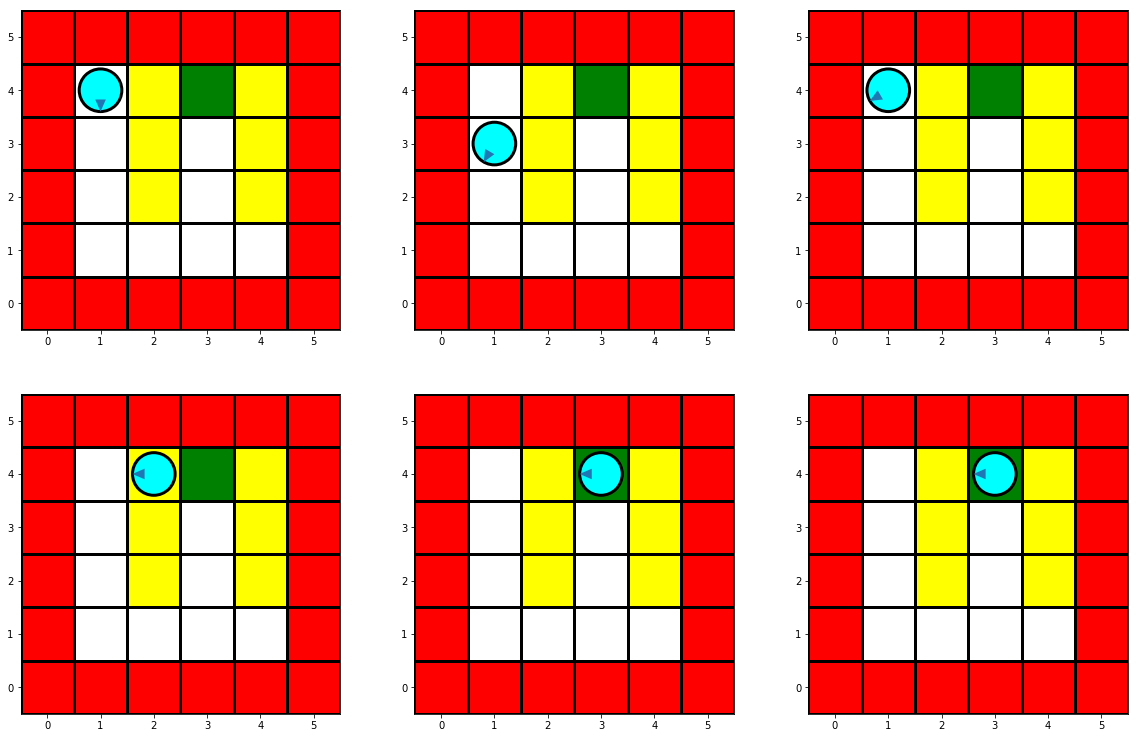

In [229]:
########
# 3(c) #
########

gb = GameBoard(C=6,R=6,error_prob=0)
gb.setSpecificGameBoardForClass()
gb.moveRobotManually(d=6,c=1,r=4)
#gb.runPolicyIteration(0.9)

trajectory = gb.run()

Value Iteration took 54.8631464865 seconds to run.

forward then left turn
forward then no turn
forward then left turn
forward then no turn
forward then right turn
backward then right turn
backward then left turn
backward then right turn
no movement


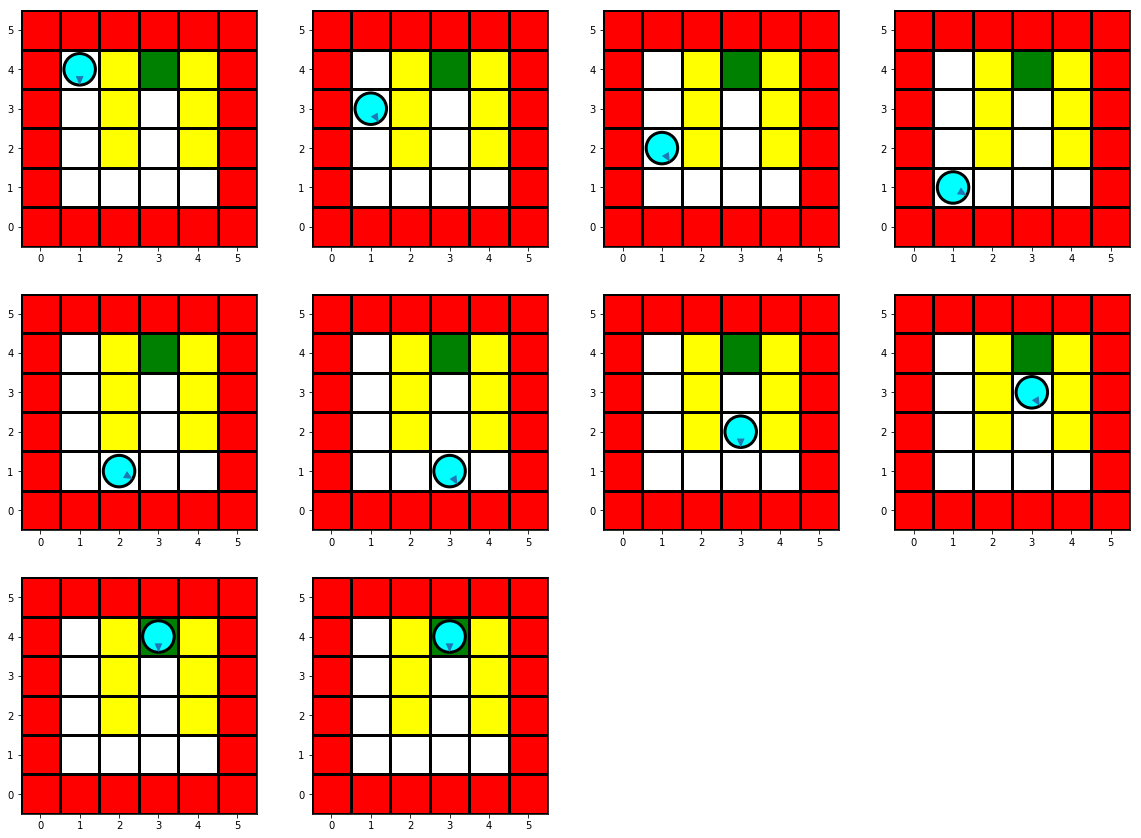

In [230]:
########
# 4(b) #
########

gb = GameBoard(C=6,R=6,error_prob=0)
gb.setSpecificGameBoardForClass()
gb.moveRobotManually(d=6,c=1,r=4)
gb.runValueIteration(0.9)

trajectory = gb.run()

Value Iteration took 78.9751465294 seconds to run.

forward then no turn
right error
forward then no turn
no movement


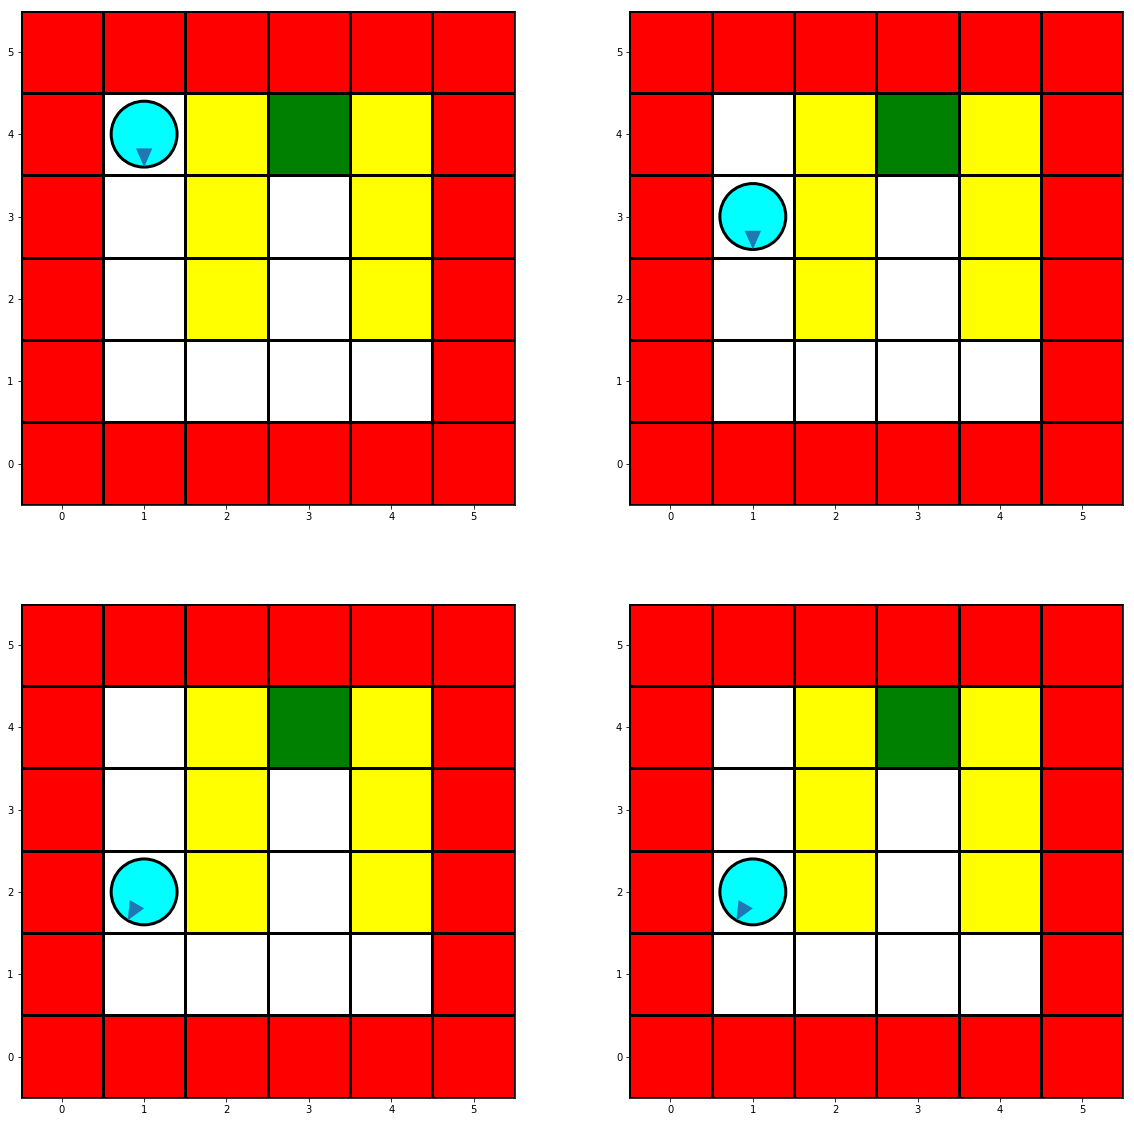

In [224]:
########
# 5(a) #
########

gb = GameBoard(C=6,R=6,error_prob=0.25)
gb.setSpecificGameBoardForClass()
gb.moveRobotManually(d=6,c=1,r=4)
gb.runPolicyIteration(0.9)

trajectory = gb.run()

Value Iteration took 86.9672915164 seconds to run.

forward then no turn
forward then no turn
forward then right turn
left error
backward then right turn
no movement


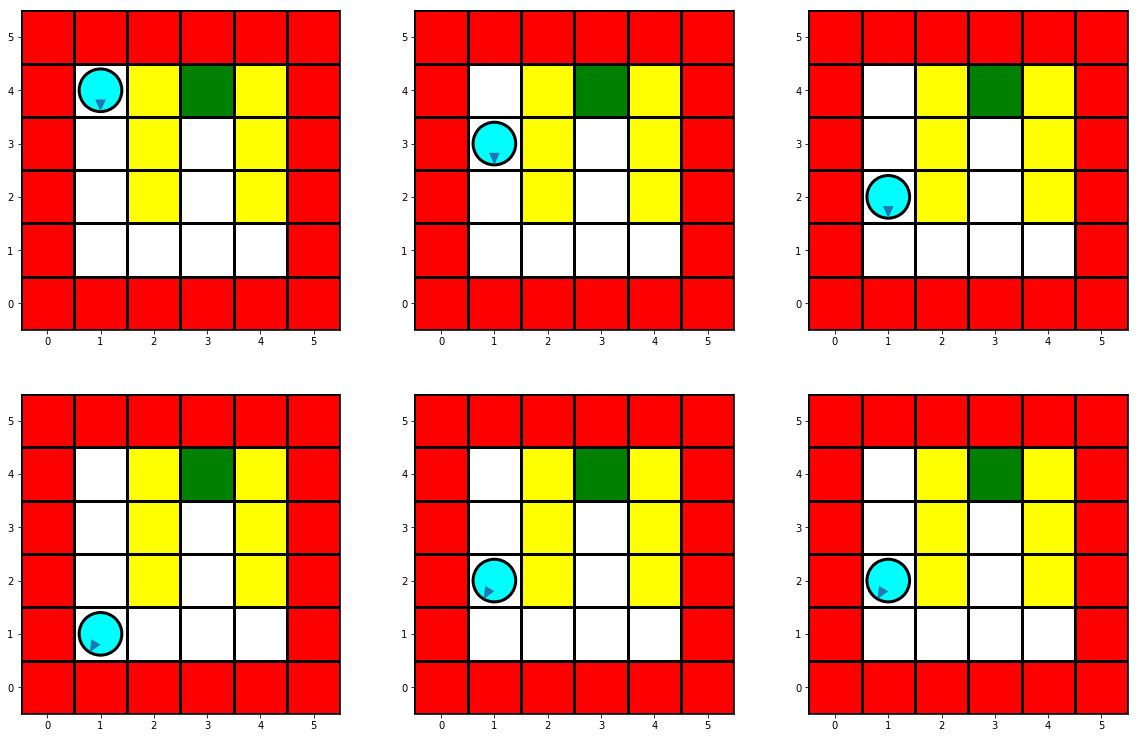

In [225]:
########
# 5(b) #
########

gb = GameBoard(C=6,R=6,error_prob=0.25)
gb.setSpecificGameBoardForClass()
gb.moveRobotManually(d=6,c=1,r=4)
gb.ss.setRewardOfAllDirectionsAtCoordinate(3,4,0) #
gb.ss.statespace[6][3][4].reward = 1
gb.ss.statespace[5][3][4].reward = 1
gb.ss.statespace[7][3][4].reward = 1
gb.runPolicyIteration(0.9)

trajectory = gb.run()

